# 모델_1 긍정/부정 분류에 사용해볼 전처리
macab 토큰화 후에 적용\
불용어제거\
임베딩층에 fasttext적용


In [135]:
import numpy as np
import pandas as pd
import re
from soynlp.normalizer import repeat_normalize
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from collections import Counter

#텐서플로우
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

#필요없는 경고무시
import warnings
warnings.filterwarnings('ignore')

#시각화용 임포트 모음
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go

In [136]:
#1. Naver Sentiment Movie Corpus v1.0 다운로드
train_file = tf.keras.utils.get_file('train.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')

#파일을 이진모드로 읽어온다. 디코드는 utf8로한다.
train_text = open(train_file,'rb').read().decode(encoding='utf-8')

#테스트용
# test_file = tf.keras.utils.get_file( 'test.txt','https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')
# test_text = open(test_file,'rb').read().decode(encoding='utf-8')


df_train = pd.DataFrame({
    'text':[ row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t')>0 ],
    'sentiment': [ int(row.split('\t')[2]) for row in train_text.split('\n')[1:] if row.count('\t')>0]
})

# 데이터 크기 지정
df_train = df_train[::4]

#널값있는지 확인
empty_string_exists = any(df_train['text'].apply(lambda x: x == ""))

if empty_string_exists:
    print("빈 문자열이 존재합니다.")
else:
    print("빈 문자열이 없습니다.")

#널값제거
#빈 문자열을 NaN 값으로 대체
df_train['text'].replace('', np.nan, inplace=True)
# NaN 값을 포함하는 행 제거
df_train.dropna( inplace=True)
df_train


빈 문자열이 없습니다.


,text,sentiment
0,아 더빙.. 진짜 짜증나네요 목소리,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
8,액션이 없는데도 재미 있는 몇안되는 영화,1
12,울면서 손들고 횡단보도 건널때 뛰쳐나올뻔 이범수 연기 드럽게못해,0
16,참 사람들 웃긴게 바스코가 이기면 락스코라고 까고바비가 이기면 아이돌이라고 깐다.그...,1
...,...,...
149980,"아, 진짜 웃긴다...프랑스 영화 정말 싫어했었는데 이 영화는 열외~",1
149984,수술할정도로 아파본사람들만이 제대로 동감할수 있는영화..삶의 소중함.과 고마움...,1
149988,와~ 이런 것도 영화라고... 차라리 뮤직비디오를 만드는 게 나을 뻔,0
149992,공포나 재난영화가 아니라 아예 대놓고 비급 크리쳐개그물임ㅋㅋ 음악 완전 흥겹다ㅋ 5...,0


In [137]:
# train 데이터 입력값(X)을 정제(Cleaning)
def clean_korean_text(text):
    # 특수 문자 및 숫자 제거
    text = re.sub(r'[^가-힣ㄱ-ㅎㅏ-ㅣ\s]', ' ', text)
    # 반복되는 자음, 모음 제거 (e.g., 'ㅋㅋㅋ' -> 'ㅋ')
    text = repeat_normalize(text, num_repeats=1)
    # 띄어쓰기 정규화 (연속된 공백 문자를 하나의 공백 문자로 변환)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


df_train['text']=df_train['text'].apply(lambda x:clean_korean_text(x))
df_train


,text,sentiment
0,아 더빙 진짜 짜증나네요 목소리,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
8,액션이 없는데도 재미 있는 몇안되는 영화,1
12,울면서 손들고 횡단보도 건널때 뛰쳐나올뻔 이범수 연기 드럽게못해,0
16,참 사람들 웃긴게 바스코가 이기면 락스코라고 까고바비가 이기면 아이돌이라고 깐다 그...,1
...,...,...
149980,아 진짜 웃긴다 프랑스 영화 정말 싫어했었는데 이 영화는 열외,1
149984,수술할정도로 아파본사람들만이 제대로 동감할수 있는영화 삶의 소중함 과 고마움,1
149988,와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔,0
149992,공포나 재난영화가 아니라 아예 대놓고 비급 크리쳐개그물임ㅋㅋ 음악 완전 흥겹다ㅋ 점...,0


In [138]:
#빈문자열 존재 확인
empty_string_exists = any(df_train['text'].apply(lambda x: x == ""))

if empty_string_exists:
    print("빈 문자열이 존재합니다.")
else:
    print("빈 문자열이 없습니다.")

빈 문자열이 존재합니다.


In [139]:
#빈문자열제거
df_train.drop(df_train[df_train['text'] == ""].index, inplace=True)

empty_string_exists = any(df_train['text'].apply(lambda x: x == ""))
if empty_string_exists:
    print("빈 문자열이 존재합니다.")
else:
    print("빈 문자열이 없습니다.")

빈 문자열이 없습니다.


,sentiment,text
1,positive,18652
0,negative,18514


<AxesSubplot:xlabel='sentiment', ylabel='count'>

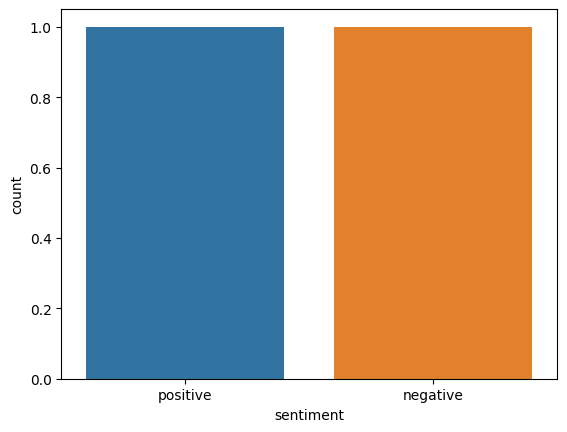

In [140]:
#긍정/부정 분포 시각화
temp = df_train.groupby('sentiment').count().reset_index().sort_values(by='text',ascending=False)
temp['sentiment']=temp['sentiment'].replace({0:'negative',1:'positive'})
display(temp)

# plt.figure(figsize=(12,6)) #크기조절
sns.countplot(x='sentiment',data=temp)

In [141]:
#정제된 텍스트를 mecab토큰화한다 ,여기서는 임시로 Okt
from konlpy.tag import Mecab
mecab=Mecab(dicpath=r'C:\mecab\mecab-ko-dic')
df_train['text']=df_train['text'].apply(lambda x: mecab.morphs(x))
df_train

,text,sentiment
0,"[아, 더, 빙, 진짜, 짜증, 나, 네요, 목소리]",0
4,"[사이몬페그, 의, 익살, 스런, 연기, 가, 돋보였, 던, 영화, 스파이더맨, 에...",1
8,"[액션, 이, 없, 는데, 도, 재미, 있, 는, 몇, 안, 되, 는, 영화]",1
12,"[울, 면서, 손들, 고, 횡단, 보도, 건널, 때, 뛰쳐나올, 뻔, 이범수, 연기...",0
16,"[참, 사람, 들, 웃긴, 게, 바스코, 가, 이기면, 락스, 코, 라고, 까, 고...",1
...,...,...
149980,"[아, 진짜, 웃긴다, 프랑스, 영화, 정말, 싫, 어, 했었, 는데, 이, 영화,...",1
149984,"[수술, 할, 정도, 로, 아파, 본, 사람, 들, 만, 이, 제대로, 동감, 할,...",1
149988,"[와, 이런, 것, 도, 영화, 라고, 차라리, 뮤직, 비디오, 를, 만드, 는, ...",0
149992,"[공포, 나, 재난, 영화, 가, 아니, 라, 아예, 대놓고, 비급, 크리, 쳐, ...",0


In [142]:
# 긍정/부정 공통으로 단어의 등장 빈도 수 순위
bindo = Counter([token for text in df_train['text'] for token in text])
df_count = pd.DataFrame.from_dict(bindo, orient='index', columns=['count']).sort_values('count', ascending=False)

#상위10 토큰만 출력
df_count.reset_index(inplace=True)
df_count.rename(columns={'index':'word'},inplace=True)
df_count[:10].style.background_gradient(cmap='Purples')

,word,count
0,이,18392
1,는,16716
2,영화,14350
3,다,13815
4,고,11814
5,하,11222
6,도,8471
7,의,8453
8,가,8438
9,은,7836


In [143]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

#불용어 제거 적용
df_train['text'] = df_train['text'].apply(lambda x: ' '.join([word for word in x if word not in stopwords]).split() )
df_train[:10]


,text,sentiment
0,"[아, 더, 빙, 진짜, 짜증, 나, 네요, 목소리]",0
4,"[사이몬페그, 익살, 스런, 연기, 돋보였, 던, 영화, 스파이더맨, 에서, 늙, ...",1
8,"[액션, 없, 는데, 재미, 있, 몇, 안, 되, 영화]",1
12,"[울, 면서, 손들, 고, 횡단, 보도, 건널, 때, 뛰쳐나올, 뻔, 이범수, 연기...",0
16,"[참, 사람, 웃긴, 게, 바스코, 이기면, 락스, 코, 라고, 까, 고, 바비, ...",1
20,"[나름, 심오, 뜻, 있, 듯, 그냥, 학생, 선생, 놀아나, 영화, 절대, 아님]",1
24,"[주제, 좋, 은데, 중반, 부터, 지루, 하, 다]",0
28,"[재, 밋, 뎅]",1
32,"[재밌, 는데, 별점, 왜, 이리, 낮, 은고]",1
36,"[키이라, 나이틀리, 연기, 하, 고자, 했, 던, 건, 대체, 정신, 장애, 일까...",0


In [144]:
#불용어 제거후 긍정/부정 공통으로 단어의 등장 빈도 수 순위
bindo = Counter([token for text in df_train['text'] for token in text])
df_count = pd.DataFrame.from_dict(bindo, orient='index', columns=['count']).sort_values('count', ascending=False)

#상위10 토큰만 출력
df_count.reset_index(inplace=True)
df_count.rename(columns={'index':'word'},inplace=True)
df_count[:10].style.background_gradient(cmap='Blues')

,word,count
0,영화,14350
1,다,13815
2,고,11814
3,하,11222
4,을,7481
5,보,6307
6,게,5588
7,지,4712
8,있,4262
9,없,4008


리뷰의 최대 길이 : 83
리뷰의 평균 길이 : 13.544691384598828
리뷰의 90%를 포함하는 길이 : 29.0


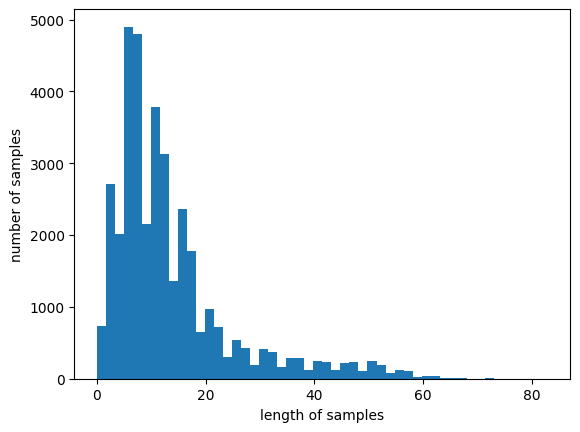

In [146]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in df_train['text']))
print('리뷰의 평균 길이 :',sum(map(len, df_train['text']))/len(df_train['text']))
print('리뷰의 90%를 포함하는 길이 :', df_train['text'].str.len().quantile(0.9) )
plt.hist([len(review) for review in df_train['text']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# 리뷰의 90%를 포함하는 길이
max_length = int(np.around(df_train['text'].str.len().quantile(0.9)))

#너무 긴 리뷰와 길이1 문자열을 삭제
df_train = df_train[(df_train['text'].str.len() >= 2) & (df_train['text'].str.len() <= max_length)]

In [147]:
# 35000개 = 실무에서 일반적으로 사용하는? 갯수
#cleaned_sentences의 빈도수 30000개 어절을 토크나이저에 fit시킴
vocab_size=35000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df_train['text'])

# tokenizer 객체를 저장
with open('GRU_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

#시퀀스데이터로 변환 ==벡터화
sequences = tokenizer.texts_to_sequences(df_train['text'])

In [148]:
#길이를 맞춰주는 패딩작업, 길이는 리뷰의 90%를 포함하는 길이로
x_train = pad_sequences(sequences, maxlen= max_length, padding='post')

In [150]:
#y값 추출, 데이터 차원 맞추기, 넘파이 배열로 변환
y_train=(df_train.iloc[:,1].to_frame()).to_numpy()
y_train

array([[0],
       [1],
       [1],
       ...,
       [1],
       [0],
       [1]], dtype=int64)

In [151]:
#시퀀스 길이확인
print(x_train[0])
x_train.shape

[  22   66 1013   25  224   12   24  595    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


(32787, 29)

패스트텍스트 학습해보기  => 임베딩층에 사전학습모델을 넣어주는것이다.

In [152]:
from gensim.models import FastText
#sg=1 : skipgram사용, 중심단어를 기준으로 주변단어예측
embedding_dim = 400
ft_model = FastText(df_train['text'], vector_size=embedding_dim, window=5, min_count=3, workers=6, sg=1)
# 완성된 임베딩 매트릭스의 크기 확인
ft_model.wv.vectors.shape

(7639, 400)

In [155]:
#어떤 토큰과 유사도가 있는지 보지, OOV인 토큰을넣어도 쌉가능
print(ft_model.wv.most_similar("이수빈"))

[('이수근', 0.9973162412643433), ('봣네', 0.9824625849723816), ('눈깔', 0.9822656512260437), ('구지성', 0.9813891649246216), ('뚱뚱', 0.9803119897842407), ('노모', 0.9790335893630981), ('다냐', 0.9789295196533203), ('못써', 0.9788704514503479), ('사도', 0.9788005352020264), ('우산', 0.9786791205406189)]


In [156]:
# 학습된 입베딩층 모델 저장
# ft_model.save("FT_LSTM_test.bin")

In [157]:
# FastText 임베딩 로드
# import fasttext
# fasttext_model = FastText.load('./FT_LSTM_test.bin')

In [158]:
tokenizer.word_index.items()

dict_items([('영화', 1), ('다', 2), ('고', 3), ('하', 4), ('을', 5), ('보', 6), ('게', 7), ('지', 8), ('없', 9), ('있', 10), ('좋', 11), ('나', 12), ('었', 13), ('만', 14), ('너무', 15), ('재밌', 16), ('는데', 17), ('봤', 18), ('정말', 19), ('음', 20), ('적', 21), ('아', 22), ('안', 23), ('네요', 24), ('진짜', 25), ('점', 26), ('로', 27), ('네', 28), ('어', 29), ('지만', 30), ('것', 31), ('최고', 32), ('기', 33), ('같', 34), ('했', 35), ('았', 36), ('않', 37), ('거', 38), ('어요', 39), ('수', 40), ('에서', 41), ('인', 42), ('말', 43), ('평점', 44), ('연기', 45), ('면', 46), ('되', 47), ('이런', 48), ('내', 49), ('주', 50), ('왜', 51), ('감동', 52), ('ㅋ', 53), ('스토리', 54), ('던', 55), ('습니다', 56), ('할', 57), ('싶', 58), ('재미있', 59), ('듯', 60), ('겠', 61), ('드라마', 62), ('재미', 63), ('해', 64), ('ㅋㅋ', 65), ('더', 66), ('함', 67), ('본', 68), ('볼', 69), ('잼', 70), ('지루', 71), ('그', 72), ('배우', 73), ('뭐', 74), ('아니', 75), ('재미없', 76), ('내용', 77), ('그냥', 78), ('만들', 79), ('생각', 80), ('때', 81), ('중', 82), ('감독', 83), ('보다', 84), ('사람', 85), ('알', 86), ('까지', 87), ('

In [159]:
fasttext_model.wv['영화']

array([-0.18244642, -0.11575259, -0.01429511,  0.00814433,  0.02376133,
       -0.2091414 ,  0.01929523,  0.0115331 , -0.21528338, -0.10141704,
       -0.04834651, -0.14431673,  0.17438348,  0.1193495 ,  0.04040759,
       -0.11942212, -0.12199847,  0.11987234, -0.03525826,  0.02806146,
        0.14287297,  0.04056367,  0.06042791,  0.02723042, -0.17182562,
       -0.01486638,  0.15126511, -0.1424455 , -0.07815889,  0.18812113,
        0.15869015, -0.04356963,  0.10669452, -0.26369852,  0.18599975,
       -0.01338581,  0.1753813 ,  0.0748391 , -0.08044943, -0.14587307,
        0.0242804 , -0.05833697,  0.01873157, -0.09140768,  0.02186801,
        0.12587345,  0.08027287,  0.01876254,  0.08659546, -0.07434706,
       -0.03073911,  0.0796348 , -0.09772216, -0.00828242,  0.01640215,
       -0.07312196, -0.04485704,  0.10589041, -0.00521994, -0.00568173,
        0.13637641, -0.08619409,  0.08682282, -0.05753475, -0.09263154,
       -0.06850346, -0.03527703,  0.09909865, -0.14613238,  0.04

In [160]:
# 임베딩 매트릭스 생성
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = fasttext_model.wv[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
#전처리끝 모델시작

## RNN계열 모델 가져와서 학습시키기

In [ ]:
from tensorflow.keras.layers import B

In [162]:
# LSTM 모델 정의
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense,Dropout, LSTM, GRU,Bidirectional,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False),
    Bidirectional(GRU(64, dropout=0.3, recurrent_dropout=0.3)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 훈련
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stop])

Epoch 1/50
410/410 [==============================] - 90s 182ms/step - loss: 0.5124 - accuracy: 0.7562 - val_loss: 0.4708 - val_accuracy: 0.7784
Epoch 2/50
410/410 [==============================] - 65s 158ms/step - loss: 0.4488 - accuracy: 0.7920 - val_loss: 0.4192 - val_accuracy: 0.8041
Epoch 3/50
410/410 [==============================] - 68s 166ms/step - loss: 0.4296 - accuracy: 0.7983 - val_loss: 0.4274 - val_accuracy: 0.7966
Epoch 4/50
410/410 [==============================] - 72s 176ms/step - loss: 0.4213 - accuracy: 0.8048 - val_loss: 0.4113 - val_accuracy: 0.8059
Epoch 5/50
410/410 [==============================] - 64s 157ms/step - loss: 0.4165 - accuracy: 0.8085 - val_loss: 0.4132 - val_accuracy: 0.8074
Epoch 6/50
410/410 [==============================] - 64s 156ms/step - loss: 0.4096 - accuracy: 0.8109 - val_loss: 0.4047 - val_accuracy: 0.8080
Epoch 7/50
410/410 [==============================] - 63s 154ms/step - loss: 0.4043 - accuracy: 0.8152 - val_loss: 0.4067 - val_ac

KeyboardInterrupt: 

In [ ]:
model.save('GRU_model_1.h5')

### 카톡 서비스 예측

In [ ]:
# 저장된 모델 불러오기
# from tensorflow.keras.models import load_models
# model= load_models('GRU_model_1.h5')

In [ ]:
# 카톡대화 불러와서 정제,(정규화코드)하는 함수
import re

def get_from_txt(txt):
    data= open(txt,"r", encoding='utf-8').read().split('\n')
    sentences=[]
    for line in data:
        pattern = r'\[(.*?)\]\s+\[(.*?)\]\s+(.+)'
        match = re.match(pattern, line)
        if match:
            name = match.group(1)  # 첫 번째 대괄호 안의 단어 추출
            time = match.group(2)  # 두 번째 대괄호 안의 단어 추출
            content = match.group(3)  # 대괄호 뒤의 내용 추출
            # print(name, time, content)
            temp=[name,time,content]
            sentences.append(temp)    
    return sentences

#함수확인
get_from_txt('sample.txt')

In [ ]:
#참여자 뽑기

# 저장된 모델 불러오기
# from tensorflow.keras.models import load_models
# model= load_models('4_6_DNN 토큰화수정.h5')


#입력된 이름의 '대화내역만' 담기
received_texts= []
for i in get_from_txt('sample.txt'): 
    if i[0] == target_name:
        received_texts.append( i[2] )
        
# 이모티콘, 사진, 샵검색 제거 
clean_received_texts2 = []
for i in received_texts:
    if '샵검색:' not in i: 
        if "이모티콘" not in i:
            if '샵검색:' not in i:
                clean_received_texts2.append(str(i))

#=========== 이쯤에서 답장시간 계산기 구현   =======================
          
          
#텍스트 정제  
clean_received_texts2= [clean_korean_text(i) for i in clean_received_texts2]



#정제된 텍스트를 벡터화하기전에 토큰화한다
from konlpy.tag import Okt
tokenized_clean_test_texts2 =[ Okt().morphs(i) for i in clean_received_texts2 ]

#이미 토큰화된걸 ' ' 공백한칸을 기준으로 다시 합쳐준다.
rejoined_tokenized_test_texts2 = [' '.join(i) for i in tokenized_clean_test_texts2]


# # 학습된 TF-IDF 벡터라이저로 테스트 데이터 변환
X_received_texts = vectorizer.transform(rejoined_tokenized_test_texts2)
X_received_texts_dense = X_received_texts.toarray()


# # 모델을 사용하여 예측 수행
predictions = np.round(model.predict(X_received_texts_dense))
#예측 결과 출력 (긍정: 1, 부정: 0)
print(predictions.squeeze().tolist()) #차원을 축소하고 리스트객체로 변환

cnt0=0;cnt1=0
for i in predictions.squeeze().tolist():
    if int(i)==0:
        cnt0+=1
    else:
        cnt1+=1

#부정과 긍정문의 갯수
print('부정문과 긍정문의 갯수:',cnt0,cnt1)
#막대그래프 => 프론트에서 

#긍정과 부정의 비율( 긍정문의 수 / 부정문의 수)
print('긍정과 부정의 비율: ',cnt1/cnt0)
#숫자가 1이상이고 높을수록 긍정적이다.

